In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import math
import os
from numpy.linalg import norm

drive = os.listdir()
drive

['.config', 'gdrive', 'sample_data']

In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/ImageCLEF2023/Imageclef2023_all_in_one.csv', sep='\t', encoding='latin')

In [ ]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
df.head(5)

ID  \
0  ImageCLEFmedical_Caption_2023_train_000001   
1  ImageCLEFmedical_Caption_2023_train_000002   
2  ImageCLEFmedical_Caption_2023_train_000003   
3  ImageCLEFmedical_Caption_2023_train_000004   
4  ImageCLEFmedical_Caption_2023_train_000005   

                                  cuis  \
0                             C0040405   
1                             C0041618   
2           C0040405;C0817096;C0205271   
3  C0002978;C0036033;C0262950;C0225317   
4           C0040405;C0817096;C0497156   

                                             caption  
0            Head CT demonstrating left parotiditis.  
1  Acquired renal cysts in end-stage renal failur...  
2  Computed tomography of the chest showing the r...  
3  Lateral view of the sacrum showing the low con...  
4  Thoracic CT scan showing perihilar pulmonary l...

In [ ]:
concepts_mapper = pd.read_csv('/content/gdrive/MyDrive/imageclef23/ImageCLEFmedical_Caption_2023_cui_mapping.csv', sep="\t", header=None, names=['cui', 'concept'])

# Build a mapper
_concepts_dict = {}
for row in concepts_mapper['concept']:
    mapper = concepts_mapper.loc[concepts_mapper['concept'] == row].values.flatten().tolist()
    _concepts_dict[mapper[0]] = mapper[1]

In [ ]:
_concepts_dict

{'C0016522': 'Foramen Ovale, Patent',
 'C0457846': 'Cervical segment of spinal cord',
 'C0578537': 'Cavitation of lung',
 'C0179751': 'Epidural catheter',
 'C3489393': 'Hiatal Hernia',
 'C0730166': 'Bone structure of fifth metacarpal',
 'C1261077': 'Structure of left lower lobe of lung',
 'C0152443': 'Urethral diverticulum',
 'C0227301': 'Descending part of duodenum',
 'C0031354': 'Pharyngeal structure',
 'C4039172': 'Posterior point of nasal spine',
 'C0227387': 'Left colic flexure',
 'C0227385': 'Hepatic flexure of colon',
 'C0228126': 'Leptomeninges',
 'C0230436': 'Popliteal fossa structure',
 'C0037922': 'Spinal Canal',
 'C1260954': 'Morphologically altered structure',
 'C0580663': 'Tomography - chest',
 'C0450184': 'Jejunal loop',
 'C0729936': 'Cardiac chamber structure',
 'C0032718': 'Portal vein structure',
 'C0149543': 'Base of skull structure',
 'C0027540': 'Necrosis',
 'C0582254': 'Entire intrahepatic part of main portal vein',
 'C0227375': 'Ascending colon',
 'C0006441': 'Sy

In [ ]:
# Create new column and fill it with nan values
df['concepts'] = np.nan

# Iterate through the dataframe and fill the column with either the real-world medical concept (if available), or the CUI.
for i, cuis in enumerate(df['cuis']):
    tags = []
    for tag in cuis.split(';'):
        if tag in _concepts_dict.keys():
            tags.append(_concepts_dict[tag])
        else:
            tags.append(tag)
    df['concepts'][i] = ';'.join(tags)

<ipython-input-7-66c78152f4c4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['concepts'][i] = ';'.join(tags)


In [ ]:
# print dataframe
df.head()

ID  \
0  ImageCLEFmedical_Caption_2023_train_000001   
1  ImageCLEFmedical_Caption_2023_train_000002   
2  ImageCLEFmedical_Caption_2023_train_000003   
3  ImageCLEFmedical_Caption_2023_train_000004   
4  ImageCLEFmedical_Caption_2023_train_000005   

                                  cuis  \
0                             C0040405   
1                             C0041618   
2           C0040405;C0817096;C0205271   
3  C0002978;C0036033;C0262950;C0225317   
4           C0040405;C0817096;C0497156   

                                             caption  \
0            Head CT demonstrating left parotiditis.   
1  Acquired renal cysts in end-stage renal failur...   
2  Computed tomography of the chest showing the r...   
3  Lateral view of the sacrum showing the low con...   
4  Thoracic CT scan showing perihilar pulmonary l...   

                                            concepts  
0                          X-Ray Computed Tomography  
1                                    Ultrasonography  
2          X-Ray Computed Tomography;Chest;Irregular  
3  angiogram;Sacral Region;Skeletal bone;soft tissue  
4    X-Ray Computed Tomography;Chest;Lymphadenopathy

In [ ]:
tags_dict = dict()
for concepts in df['concepts']:
  tags = concepts.split(';')
  for t in tags:
    if t not in tags_dict.keys():
      tags_dict[t] = 0

In [ ]:
import pickle

# Load fasttext embeddings
fasttext_embed = np.load("/content/gdrive/My Drive/fasttext.npy")
fasttext_word_to_index = pickle.load(open("/content/gdrive/My Drive/fasttext_voc.pkl", 'rb'))


In [ ]:
# initialize bioclinical-BERT instance
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
# save concepts and captions into list
df_concepts, df_captions = list(df['concepts']), list(df['caption'])
for i, item in enumerate(df_concepts):
  df_concepts[i] = item.split(';')
df_concepts, df_captions

([['X-Ray Computed Tomography'],
  ['Ultrasonography'],
  ['X-Ray Computed Tomography', 'Chest', 'Irregular'],
  ['angiogram', 'Sacral Region', 'Skeletal bone', 'soft tissue'],
  ['X-Ray Computed Tomography', 'Chest', 'Lymphadenopathy'],
  ['X-Ray Computed Tomography'],
  ['X-Ray Computed Tomography', 'Pelvis', 'Acute abscess'],
  ['X-Ray Computed Tomography',
   'Ventriculoperitoneal catheter',
   'RIght lateral ventricle structure'],
  ['X-Ray Computed Tomography',
   'Left lateral ventricle structure',
   'Structure of parenchyma of lung',
   'Hemorrhage',
   'Right frontal lobe structure',
   'Ventricular hemorrhage'],
  ['X-Ray Computed Tomography'],
  ['X-Ray Computed Tomography', 'Skeletal bone'],
  ['Magnetic Resonance Imaging', 'Cerebellar hemisphere structure'],
  ['Magnetic Resonance Imaging', 'Nodule', 'Spinal Cord', 'Cauda Equina'],
  ['Magnetic Resonance Imaging', 'Fluid behavior'],
  ['X-Ray Computed Tomography'],
  ['X-Ray Computed Tomography', 'Bronchi'],
  ['Ultrasono

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm',disable=["tagger", "parser","ner"])
nlp.add_pipe('sentencizer')

# Define function that tokenizes the given structure using the SpaCy library
def tokenize_samples(samples):

  tokenized_samples = []
  for i in range(len(samples)):
    doc = nlp(samples[i])  # Tokenize the sample into sentences
    tokens = []
    for sent in doc.sents:
      for tok in sent:  # Iterate through the words of the sentence
        if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
          continue
        if tok.text.strip():
          tokens.append(tok.text.replace('"',"'").strip())
    tokenized_samples.append(tokens)

  return tokenized_samples

# Tokenize the captions
df_captions_tokenized = tokenize_samples(df_captions)

# And print them!
print('captions tok:', df_captions_tokenized)

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# Take a look in the first 20 concept lists and tokenized captions
print('DF CONCEPTS:', df_concepts[:20])
print('\nDF CAPTIONS TOK:', df_captions_tokenized[:20])

DF CONCEPTS: [['X-Ray Computed Tomography'], ['Ultrasonography'], ['X-Ray Computed Tomography', 'Chest', 'Irregular'], ['angiogram', 'Sacral Region', 'Skeletal bone', 'soft tissue'], ['X-Ray Computed Tomography', 'Chest', 'Lymphadenopathy'], ['X-Ray Computed Tomography'], ['X-Ray Computed Tomography', 'Pelvis', 'Acute abscess'], ['X-Ray Computed Tomography', 'Ventriculoperitoneal catheter', 'RIght lateral ventricle structure'], ['X-Ray Computed Tomography', 'Left lateral ventricle structure', 'Structure of parenchyma of lung', 'Hemorrhage', 'Right frontal lobe structure', 'Ventricular hemorrhage'], ['X-Ray Computed Tomography'], ['X-Ray Computed Tomography', 'Skeletal bone'], ['Magnetic Resonance Imaging', 'Cerebellar hemisphere structure'], ['Magnetic Resonance Imaging', 'Nodule', 'Spinal Cord', 'Cauda Equina'], ['Magnetic Resonance Imaging', 'Fluid behavior'], ['X-Ray Computed Tomography'], ['X-Ray Computed Tomography', 'Bronchi'], ['Ultrasonography', 'Bone structure of cranium'], ['

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 50000
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = fasttext_embed.shape[1]

# Init tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='__UNK__')
# num_words: the maximum number of words to keep, based on word frequency.
# oov_token: will be used to replace OOV WORDS

# Fit tokenizer (Updates internal vocabulary based on a list of texts.)
tokenizer.fit_on_texts([" ".join(x) for x in df_captions_tokenized])

# Converts text to sequences of IDs
train_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in df_captions_tokenized])

# Pad the training sequences
train_data = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


#--------------------------------------------------------------------------------------------

# Init tokenizer
tokenizer2 = Tokenizer(num_words=len(df_concepts), oov_token='__UNK__')
# num_words: the maximum number of words to keep, based on word frequency.
# oov_token: will be used to replace OOV WORDS

# Fit tokenizer (Updates internal vocabulary based on a list of texts.)
tokenizer2.fit_on_texts([" ".join(x) for x in df_concepts])

# Converts text to sequences of IDs
train_seqs2 = tokenizer2.texts_to_sequences([" ".join(x) for x in df_concepts])

# Pad the training sequences
train_data2 = pad_sequences(train_seqs2, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


In [ ]:
# Save the word index from TensorFlow's tokenizer
word_index = tokenizer.word_index
word_index2 = tokenizer2.word_index

print('Found {} unique tokens.\n'.format(len(word_index)))
print('Found {} unique tokens2.\n'.format(len(word_index2)))

word_index.update(word_index2)
print('Found {} unique tokens2.\n'.format(len(word_index)))
print(word_index)

import pickle

# the hist_train pkl file will essentially contain the train histograms for each tag
# it is calculated as: for each caption that comprises the tag, retrieve the max cosine similarity between the tag and the caption's words!
# save dictionary to pickle file
with open('word_index.pkl', 'wb') as file:
    pickle.dump(word_index, file, protocol=pickle.HIGHEST_PROTOCOL)

Found 35425 unique tokens.

Found 1607 unique tokens2.

Found 35480 unique tokens2.

{'__UNK__': 1, 'showing': 2, 'right': 18, 'left': 15, 'ct': 23, 'arrow': 6, 'image': 7, 'scan': 141, 'chest': 10, 'tomography': 6, 'computed': 7, 'shows': 12, 'view': 13, 'mass': 392, 'contrast': 19, 'x': 2, 'axial': 649, 'mri': 155, 'artery': 20, 'ray': 3, 'radiograph': 722, 'arrows': 22, 'patient': 1373, 'lesion': 354, 'demonstrating': 25, 'white': 229, 'abdomen': 22, 'anterior': 13, 'abdominal': 94, 'coronal': 559, '2': 548, '1': 32, 'bilateral': 179, 'lateral': 191, 'lung': 27, 'imaging': 9, 'posterior': 17, 'red': 38, 'year': 39, 'old': 40, 'showed': 41, 'large': 382, 'weighted': 469, 'pulmonary': 37, 'sagittal': 39, 'cm': 46, 'wall': 93, 'lower': 28, 'enhanced': 1000, 'resonance': 12, 'lobe': 29, 'magnetic': 11, 'ultrasound': 172, 't2': 54, '3': 1245, 'upper': 44, 'small': 128, 'line': 965, 'seen': 59, 'bone': 16, 'pelvis': 25, 'vein': 55, 'multiple': 452, 'level': 299, 'ventricle': 71, 'tumor': 

In [ ]:
# Previously, we saved all fasttext embeddings to a NumPy array for quick access
# Now, we save the fasttext embeddings for the words that we only need, based on the tokenizer

embedding_matrix = np.zeros((len(word_index)+2, EMBEDDING_DIM))  # +2 (pad, unkown)

for word, i in word_index.items():
    if i > len(word_index):
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        embedding_matrix[i] = np.ones(300)
print('Size of Embedding Matrix:', len(embedding_matrix))
print('Embedding Matrix:', embedding_matrix)

np.save('embedding_matrix.npy', embedding_matrix)

Size of Embedding Matrix: 35482
Embedding Matrix: [[ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.0789 -0.1382  0.3439 ...  0.0467 -0.3636 -0.1238]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]


In [ ]:
# Define function that calculates the given text's word embeddings centroid.
def text_centroid(text, model, word_index):
    """ Calculate centroid function """
    text_vec =[]
    counter = 0
    text = text.split(" ")
    for word in text:
      """if word in STOP_WORDS:
        continue"""
      try:
        if (counter == 0):
          text_vec = model[word_index[word.lower()]]
        else:
          text_vec = np.add(text_vec, model[word_index[word.lower()]])
        counter+=1
      except:
        pass

    return np.asarray(text_vec) / counter

In [ ]:
# Define function that calculates the word embeddings of each item in the given list
def get_concept_word_embeddings(_concepts:list, dims):

  concepts_embeddings = list()
  if dims == 2:
    for i, clist in enumerate(_concepts):
      concepts_embeddings.append([])
      for c in clist:
        c = c.replace('-', ' ')
        c = c.replace('.', ' ')
        c = c.replace(':', ' ')
        c = c.replace('[', ' ')
        c = c.replace(']', ' ')
        c = c.replace('(', ' ')
        c = c.replace(')', ' ')
        c = c.replace('=', ' ')
        c = c.replace('/', ' ')


        if ((len(c.split(' ')) == 1)):
          # if tag is only one word --> word_embedding(tag)
          if c.lower() in word_index:
            print(embedding_matrix[word_index[c.lower()]])
            concepts_embeddings[i].append(embedding_matrix[word_index[c.lower()]])
          else:
            concepts_embeddings[i].append(np.ones(300))
        else:
          # else if tag is more than one word --> centroid of words embeddings of each tag subword
          concepts_embeddings[i].append(text_centroid(c, embedding_matrix, word_index))
  elif dims == 1:

     for i, c in enumerate(_concepts):

        c = c.replace('-', ' ')
        c = c.replace('.', ' ')
        c = c.replace(':', ' ')
        c = c.replace('[', ' ')
        c = c.replace(']', ' ')
        c = c.replace('(', ' ')
        c = c.replace(')', ' ')
        c = c.replace('=', ' ')
        c = c.replace('/', ' ')

        if ((len(c.split(' ')) == 1)):
          # if tag is only one word --> word_embedding(tag)
          if c.lower() in word_index:
            #print(embedding_matrix[word_index[c.lower()]])
            concepts_embeddings.append(embedding_matrix[word_index[c.lower()]])
          else:
            concepts_embeddings.append(np.zeros(300))
        else:
          # else if tag is more than one word --> centroid of words embeddings of each tag subword
          concepts_embeddings.append(text_centroid(c, embedding_matrix, word_index))

  return concepts_embeddings

In [ ]:
def fine_captions(_captions:list):
  to_delete = ['(', ')', '.', ',', ]
  for i, caption in enumerate(_captions):
    for word in caption:
      if word in to_delete:
        _captions[i].remove(word)

  return _captions

In [ ]:
def get_captions_word_embeddings(_captions:list, dims):

  captions_embeddings = list()

  if dims == 2:
    for i, clist in enumerate(_captions):
      captions_embeddings.append([])
      for c in clist.split(' '):
        c = c.replace('-', ' ')
        c = c.replace('.', ' ')
        c = c.replace(':', ' ')
        c = c.replace('[', ' ')
        c = c.replace(']', ' ')
        c = c.replace('(', ' ')
        c = c.replace(')', ' ')
        c = c.replace('=', ' ')
        c = c.replace('/', ' ')


        if ((len(c.split(' ')) == 1)):
          if c.lower() in word_index:
            captions_embeddings[i].append(embedding_matrix[word_index[c.lower()]])
          else:
            captions_embeddings[i].append(np.ones(300))
        elif ((len(c.split()) > 1) and (len(text_centroid(c, embedding_matrix, word_index)) > 0)):
          captions_embeddings[i].append(text_centroid(c, embedding_matrix, word_index))
        else:
          captions_embeddings[i].append(np.ones(300))

  elif dims == 1:
    for i, c in enumerate(_captions):
      c = c.replace('-', ' ')
      c = c.replace('.', ' ')
      c = c.replace(':', ' ')
      c = c.replace('[', ' ')
      c = c.replace(']', ' ')
      c = c.replace('(', ' ')
      c = c.replace(')', ' ')
      c = c.replace('=', ' ')
      c = c.replace('/', ' ')

      if ((len(c.split(' ')) == 1)):
        captions_embeddings.append(embedding_matrix[word_index[c.lower()]])
      elif ((len(c.split()) > 1) and (len(text_centroid(c, embedding_matrix, word_index)) > 0)):
        captions_embeddings.append(text_centroid(c, embedding_matrix, word_index))
      else:
        captions_embeddings[i].append(np.ones(300))


  return captions_embeddings

In [ ]:
# compute cosine similarity
def cosine_sim(A, B):
  cosine = np.dot(A,B)/(norm(A)*norm(B))
  return cosine

In [ ]:
# function that computes the cosine similarity betwen each tag and each caption word.
def compute_similarities(concepts_embeds:list, captions_embeds:list):

  similarities = list()
  for i, tags_i in enumerate(concepts_embeds):
    similarities.append([])
    for j in range(len(tags_i)):
      similarities[i].append([])
      for k in range(len(captions_embeds[i])):
        similarities[i][j].append(cosine_sim(concepts_embeds[i][j], captions_embeds[i][k]))
    return similarities

In [ ]:
# ALT - function that computes the cosine similarity betwen each tag and each caption word.
def compute_sims(concepts_embeds:list, captions_embeds:list):

  similarities = list()
  for i, tags_i in enumerate(concepts_embeds):
    similarities.append([])
    for k in range(len(captions_embeds)):
      similarities[i].append(cosine_sim(concepts_embeds[i], captions_embeds[k]))
  return similarities

In [ ]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [ ]:
# Initial approach:
#    1. Iterate through all the captions.
#    2. For each caption, retrieve the tags.
#    3. Compute the cosine similarity between each tag and each word caption.
#    4. Add the max cosine similarity between the tag and the caption's words in the resepctiv dictionary position (the tag is the key).

# First, initialize the dictionary.

targets = set(flatten(df_captions))
print(targets)
print('Targets length:', len(targets)) # must be 2125 tags

max_cosines_dict = dict()
for target in targets:
  max_cosines_dict[target] = 0 # initialize with zero


{'Í', '\x99', '\x88', 's', 'b', 'D', '\x9a', '¥', '±', '1', '\xa0', 'L', '³', '°', '®', '\xad', '+', 'S', '\x97', '^', 'C', '#', 'H', '\x98', '.', 'l', 'º', '\x86', '\\', 'x', '6', 'ï', 'i', 'Å', 'I', '`', 'o', 'v', 'G', 'Ä', '´', '»', 'z', '½', ',', '\x8a', '0', '¤', '¸', 'm', '¢', 'h', 'ª', 'F', 'Ï', '\x94', 'U', '8', 'Ì', '\x9e', '\x8b', '|', '\x91', 'M', '\x92', '\x95', '!', '"', '}', '/', '\x9f', 'y', '\x9b', 'B', '\x8c', '@', '{', 'N', 'k', '¶', '¿', 'A', '\x90', '\x8e', '²', '%', 'j', '*', '\x83', '~', '\x9c', '¡', '\x84', 'T', '\x96', 'Î', ']', 'X', '£', 'p', 'P', '&', 'Z', '3', 'Y', 'q', '[', 'Q', ')', '¨', 'V', 't', 'd', '©', ':', '\x85', 'Â', '2', '(', 'E', '?', 'R', '5', 'â', '-', '>', '$', 'O', ';', '4', 'n', 'W', '¦', '¬', '7', '\x81', "'", 'µ', '\x82', '·', '¯', 'g', '\x89', '\x93', 'c', 'K', 'Ã', '9', 'e', '¼', 'r', '<', 'a', '=', 'Ð', '_', 'u', 'f', 'w', 'J', 'á', '¹', '«', '§', ' ', '\x87', '¾', '\x80', '\x9d'}
Targets length: 169


In [ ]:
# Start iterating through all the captions.
respective_tags = list()
concepts_embeddings = list()
captions_embeddings = get_captions_word_embeddings(df_captions, dims=2)
for i, caption in enumerate(df_captions): #df_captions is a list of length 71355, where each list item is one caption.
  tags = df_concepts[i]
  #print('Tags:', tags)
  #print('Caption:', caption)
  tags_embeddings = get_concept_word_embeddings(tags, dims=1)
  concepts_embeddings.append(tags_embeddings)
  respective_tags.append(tags)


In [ ]:
for i, caption in enumerate(df_captions):
  if i <= 20:
    print(f'caption {i}:', caption)
    print(f'concept(s) {i}:', df_concepts[i])
  else:
    break

caption 0: Head CT demonstrating left parotiditis.
concept(s) 0: ['X-Ray Computed Tomography']
caption 1: Acquired renal cysts in end-stage renal failure: 16-year-old girl with Alport syndrome and peritoneal dialysis from the age of 2Â years
concept(s) 1: ['Ultrasonography']
caption 2: Computed tomography of the chest showing the right breast nodule with irregular margins
concept(s) 2: ['X-Ray Computed Tomography', 'Chest', 'Irregular']
caption 3: Lateral view of the sacrum showing the low contrast between bone and soft tissue.
concept(s) 3: ['angiogram', 'Sacral Region', 'Skeletal bone', 'soft tissue']
caption 4: Thoracic CT scan showing perihilar pulmonary lymphadenomegaly
concept(s) 4: ['X-Ray Computed Tomography', 'Chest', 'Lymphadenopathy']
caption 5: 5.1 cm x 3.4 cm x 4 cm multiloculated hepatic abscess in the inferior posterior aspect of the right lobe
concept(s) 5: ['X-Ray Computed Tomography']
caption 6: Repeat CT abdomen and pelvis showing resolution of collection with no new

In [ ]:
my_caption_0 = df_captions[0]
my_caption_0_embeddings = captions_embeddings[0]

my_concept_0 = df_concepts[0]
my_concept_0_embeddings = concepts_embeddings[0]


my_caption_1 = df_captions[20]
my_caption_1_embeddings = captions_embeddings[20]

my_concept_1 = df_concepts[20]
my_concept_1_embeddings = concepts_embeddings[20]


my_caption_2 = df_captions[9]
my_caption_2_embeddings = captions_embeddings[9]

my_concept_2 = df_concepts[9]
my_concept_2_embeddings = concepts_embeddings[9]



In [ ]:
print('CAP0:',my_caption_0)
print('CAPE0:', my_caption_0_embeddings)

print('CON0:', my_concept_0)
print('CONE0:', my_concept_0_embeddings)

print('CAP1:', my_caption_1)
print('CAPE1:', my_caption_1_embeddings)

print('CON1:', my_concept_1)
print('CONE1:', my_concept_1_embeddings)

print('CAP2:', my_caption_2)
print('CAPE2:', my_caption_2_embeddings)

print('CON2:', my_concept_2)
print('CONE2:', my_concept_2_embeddings)

CAP0: Head CT demonstrating left parotiditis.
CAPE0: [array([ 2.140e-02, -2.200e-03,  9.680e-02,  9.970e-02,  1.900e-03,
       -6.800e-03,  8.870e-02, -1.760e-02,  8.770e-02,  1.500e-02,
       -1.540e-02, -1.750e-02,  2.260e-02,  8.760e-02, -7.630e-02,
        1.146e-01, -6.740e-02, -1.092e-01, -9.570e-02, -2.270e-02,
       -3.240e-02, -1.440e-02, -4.600e-03,  8.320e-02,  5.110e-02,
       -8.940e-02, -1.189e-01, -1.830e-02,  2.680e-02,  4.260e-02,
       -9.240e-02,  8.850e-02,  5.300e-02,  8.830e-02,  1.640e-02,
       -9.500e-03, -7.310e-02,  1.315e-01, -2.130e-02, -2.570e-02,
       -8.370e-02,  1.500e-03, -1.783e-01,  1.706e-01, -1.331e-01,
       -1.280e-02,  8.340e-02, -5.870e-02, -4.520e-02, -5.000e-04,
        3.310e-02, -3.580e-02, -3.090e-02, -1.140e-02,  2.280e-02,
       -8.310e-02, -4.490e-02,  8.740e-02, -3.820e-02,  4.200e-03,
        1.260e-01,  6.980e-02,  1.509e-01, -5.410e-02,  5.480e-02,
        6.070e-02, -7.890e-02, -9.730e-02, -2.080e-02, -4.250e-02,
        

In [ ]:
print('Respective tags length:', len(respective_tags))
print('Concepts embeddings length:', len(concepts_embeddings))
print('Captions embeddings length:', len(captions_embeddings))

print(respective_tags[230])
print(df_captions[230])
print(len(concepts_embeddings[230][0]))
print(len(captions_embeddings[230][0]))

Respective tags length: 71355
Concepts embeddings length: 71355
Captions embeddings length: 71355
['Plain x-ray', 'Lower Extremity', 'Anterior-Posterior', 'Hallux Valgus']
Margo medialis pedis (MMP) method to determine hallux valgus angle.
300
300


In [ ]:
tags_dict = dict()
for concepts in df['concepts']:
  tags = concepts.split(';')
  for t in tags:
    if t not in tags_dict.keys():
      tags_dict[t] = list()

print(tags_dict)

{'X-Ray Computed Tomography': [], 'Ultrasonography': [], 'Chest': [], 'Irregular': [], 'angiogram': [], 'Sacral Region': [], 'Skeletal bone': [], 'soft tissue': [], 'Lymphadenopathy': [], 'Pelvis': [], 'Acute abscess': [], 'Ventriculoperitoneal catheter': [], 'RIght lateral ventricle structure': [], 'Left lateral ventricle structure': [], 'Structure of parenchyma of lung': [], 'Hemorrhage': [], 'Right frontal lobe structure': [], 'Ventricular hemorrhage': [], 'Magnetic Resonance Imaging': [], 'Cerebellar hemisphere structure': [], 'Nodule': [], 'Spinal Cord': [], 'Cauda Equina': [], 'Fluid behavior': [], 'Bronchi': [], 'Bone structure of cranium': [], 'Atrial Septal Defects': [], 'Ectopic kidney': [], 'Kidney': [], 'Calculi': [], 'Obstructed': [], 'Right kidney': [], 'Left kidney': [], 'Both kidneys': [], 'Heart': [], 'Arteriovenous fistula': [], 'Anterior descending branch of left coronary artery': [], 'Coronary artery': [], 'Pulmonary artery structure': [], 'Entire right sinus of Val

In [ ]:
import math
from tqdm import tqdm

# iterate through the dataset captions
for i in tqdm(range(len(captions_embeddings))):
  # for each caption compute the cosine similarity between each tag and each caption word
  # ie. if #tags = 2 and len(caption)=10, then a matrix of size (2, 10) is returned
  sims = compute_sims(concepts_embeddings[i], captions_embeddings[i])

  #print('Respective tags:', respective_tags[i])
  #print('Caption:', df_captions[i])
  #print('Len sims:', len(sims))
  #print('Sims 0:', sims[0])

  # iterate through the sims vector
  for k, rt in enumerate(sims):
    sims[k] = [x for x in sims[k] if (math.isnan(x))==False]
    if len(sims[k]) > 0:
      #print('np max sims:', np.max(sims[k]))
      tags_dict[respective_tags[i][k]].append(np.max(sims[k]))
    else:
      print('Empty sims list!')

100%|██████████| 71355/71355 [00:59<00:00, 1206.88it/s]


In [ ]:
tags_dict

{'X-Ray Computed Tomography': [0.39430608702796643,
  0.8724005296705326,
  0.8724005296705326,
  0.8724005296705326,
  0.8724005296705326,
  0.37421513077830226,
  0.37421513077830226,
  0.8724005296705326,
  0.39430608702796643,
  0.39430608702796643,
  0.8724005296705326,
  0.37421513077830226,
  0.8724005296705326,
  0.8724005296705326,
  0.39430608702796643,
  0.18144378650428508,
  0.29655870595970873,
  0.23062857258921873,
  0.8724005296705326,
  0.39430608702796643,
  0.39430608702796643,
  0.39430608702796643,
  0.39430608702796643,
  0.26757819970000996,
  0.26757819970000996,
  0.17393930901767796,
  0.8724005296705326,
  0.37421513077830226,
  0.3158341104211147,
  0.20249269241517004,
  0.8724005296705326,
  0.37421513077830226,
  0.37421513077830226,
  0.39430608702796643,
  0.286160931433236,
  0.8724005296705326,
  0.39430608702796643,
  0.29914462143156895,
  0.8724005296705326,
  0.39430608702796643,
  0.8724005296705326,
  0.39430608702796643,
  0.3168328454061537,


In [ ]:
tags_dict['Teratoma']

[1.0,
 0.2397266776231573,
 0.38565409164801845,
 0.48561513979330584,
 1.0,
 0.9220240796375562,
 0.4948911034719947,
 1.0,
 1.0,
 0.3035879245838655,
 0.355332662774294,
 0.4929122661186248,
 1.0,
 1.0]

In [ ]:
import pickle

# the hist_train pkl file will essentially contain the train histograms for each tag
# it is calculated as: for each caption that comprises the tag, retrieve the max cosine similarity between the tag and the caption's words!
# save dictionary to pickle file
with open('hist_train.pkl', 'wb') as file:
    pickle.dump(tags_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
tags_dict_1 = tags_dict['Posterior segment']

In [ ]:
tags_dict_2 = tags_dict['Pulmonary arterial hypertension']

In [ ]:
tags_dict_3 = tags_dict['Ultrasonography']

In [ ]:
tags_dict_4 = tags_dict['Plain x-ray']

In [ ]:
tags_dict[list(tags_dict.keys())[2]]

[0.9999999999999999,
 0.34400468659140604,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.44133243174532966,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.48034582450846386,
 0.9999999999999999,
 0.9999999999999999,
 0.25404615823183113,
 0.40712420459293713,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.3968031354825857,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.27466

In [ ]:
to_plot = list()
for i in range(1000):
  to_plot.append( tags_dict[list(tags_dict.keys())[i]] )

In [ ]:
import statistics
tags_dict2 = dict()
for k in tags_dict.keys():
  counter = 0
  if len(tags_dict[k]) > 0:
    tags_dict2[k] = [statistics.median(tags_dict[k]), statistics.stdev(tags_dict[k]), len(tags_dict[k])]
  else:
    counter += 1

print('Finished loop!', counter, 'lists with zero-size.')

Finished loop! 0 lists with zero-size.


In [ ]:
sorted_dict2 = {k: v for k, v in sorted(tags_dict2.items(), key=lambda item: item[1][0], reverse=False)}

In [ ]:
import pickle

# save dictionary to pickle file
with open('median_max_cos_c.pkl', 'wb') as file:
    pickle.dump(sorted_dict2, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#tags_dict['Communicable Diseases']
tags_dict['Tooth structure']
#tags_dict['Mediastinal Emphysema']
#tags_dict['Bone structure of cranium']

[0.4943498336422658,
 0.4971864185283574,
 0.9572851989493895,
 0.14250050908826972,
 0.9572851989493895,
 0.9572851989493895,
 0.9572851989493895,
 0.9572851989493895,
 0.9572851989493895,
 0.510832798193935,
 0.5692539229955543,
 0.9572851989493895,
 0.9572851989493895,
 0.3542317147982944,
 0.8862334355889404,
 0.8862334355889404,
 0.5360812409225778,
 0.9572851989493895,
 0.4469568355188112,
 0.9572851989493895,
 0.43957157252975754,
 0.6231984358074596,
 0.9572851989493895,
 0.9572851989493895,
 0.9572851989493895,
 0.4865324844046577,
 0.9999999999999999,
 0.26676830933501966,
 0.4913660481797533,
 0.4816716230370101,
 0.6357832246202886,
 0.3051675454019288,
 0.9572851989493895,
 0.4816716230370101,
 0.9572851989493895,
 0.9572851989493895,
 0.9572851989493895,
 0.4943498336422658,
 0.5692539229955543,
 0.6097653451304859,
 0.42751344908077143,
 0.9572851989493895,
 0.9572851989493895,
 0.5256428292341214,
 0.9572851989493895,
 0.9572851989493895,
 0.9572851989493895,
 0.9572851

In [ ]:
sorted_dict2

{'Aplasia, NOS': [0.17148140531790623, 0.03540600419875638, 14],
 'Bullet, device': [0.2367952283072534, 0.13364455455814409, 73],
 'Cephalometry X-ray (procedure)': [0.2516022779430119,
  0.3444918576428393,
  17],
 'Robinow Syndrome': [0.25818712865962035, 0.04139862186331479, 15],
 'Prostheses, Dental, Fixed, Crown, Total, Temporary': [0.26186523030283126,
  0.13948993002789384,
  69],
 'Probes': [0.27045383444854054, 0.08897059394780148, 194],
 'Leaking': [0.2817514017681065, 0.251520622225635, 83],
 'Dorsal pharyngeal wall structure': [0.29946306709439124,
  0.021789581615293957,
  6],
 'Stent, device': [0.30638731342524067, 0.11821951014254885, 660],
 'Cardiac chamber structure': [0.3171547015181915, 0.2275214753681667, 71],
 'Intraoperative cholangiogram': [0.3197152519433696, 0.36297695987660067, 22],
 'Arterial system': [0.32334046591398297, 0.20136291371232384, 25],
 'Coxae malum senilis': [0.3238745324018672, 0.05358589600269125, 11],
 'Plain x-ray': [0.32763121916638466, 0.

In [ ]:
for item in sorted_dict2.items():
  if item[1][0]>0.75 and item[1][1]>0.2 and item[1][2]>80:
    print(item)

('Kidney', [0.7704853443934846, 0.2017827769216418, 571])
('Vessel Positions', [0.7744731048063724, 0.20952527287671785, 457])
('Panoramic Radiography', [0.8049478034532193, 0.2427792895959315, 1292])
('Arteries', [0.80526251315187, 0.20631608229555784, 117])
('Bone structure of cranium', [0.8127250646163315, 0.2326755596130471, 3456])
('Cecum', [0.8245311767883371, 0.20768614795663218, 188])
('Joint Capsule', [0.8567518372164644, 0.24555890321813473, 420])
('Endoscopic Ultrasound', [0.8714527795758036, 0.2282475158773677, 254])
('Cholangiography', [0.8718708307905544, 0.21400722851915494, 129])
('Sacral Region', [0.8825573920798296, 0.22219868228686857, 225])
('Implants', [0.8845688672262227, 0.26232961952034417, 498])
('Shunt Device', [0.8921149684030718, 0.2139837795691567, 105])
('Collateral branch of vessel', [0.8951205845985151, 0.2006161941977582, 244])
('Structure of parenchyma of lung', [0.9361440747113372, 0.21382981701531534, 397])
('Trunk structure', [0.9428958795641509, 0.

In [ ]:
for i, key in enumerate(sorted_dict2):
  if i==185:
    print(key)

angiogram


In [ ]:
to_plot2 = list()
for i in range(len(sorted_dict2)):
  to_plot2.append( tags_dict[list(sorted_dict2.keys())[i]] )

<ipython-input-61-f685151ae901>:8: UserWarning: 
The palette list has fewer values (2) than needed (2126) and will cycle, which may produce an uninterpretable plot.
  bplot = sns.boxplot(
<ipython-input-61-f685151ae901>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  bplot.set_yticklabels(yarray, size = 19)


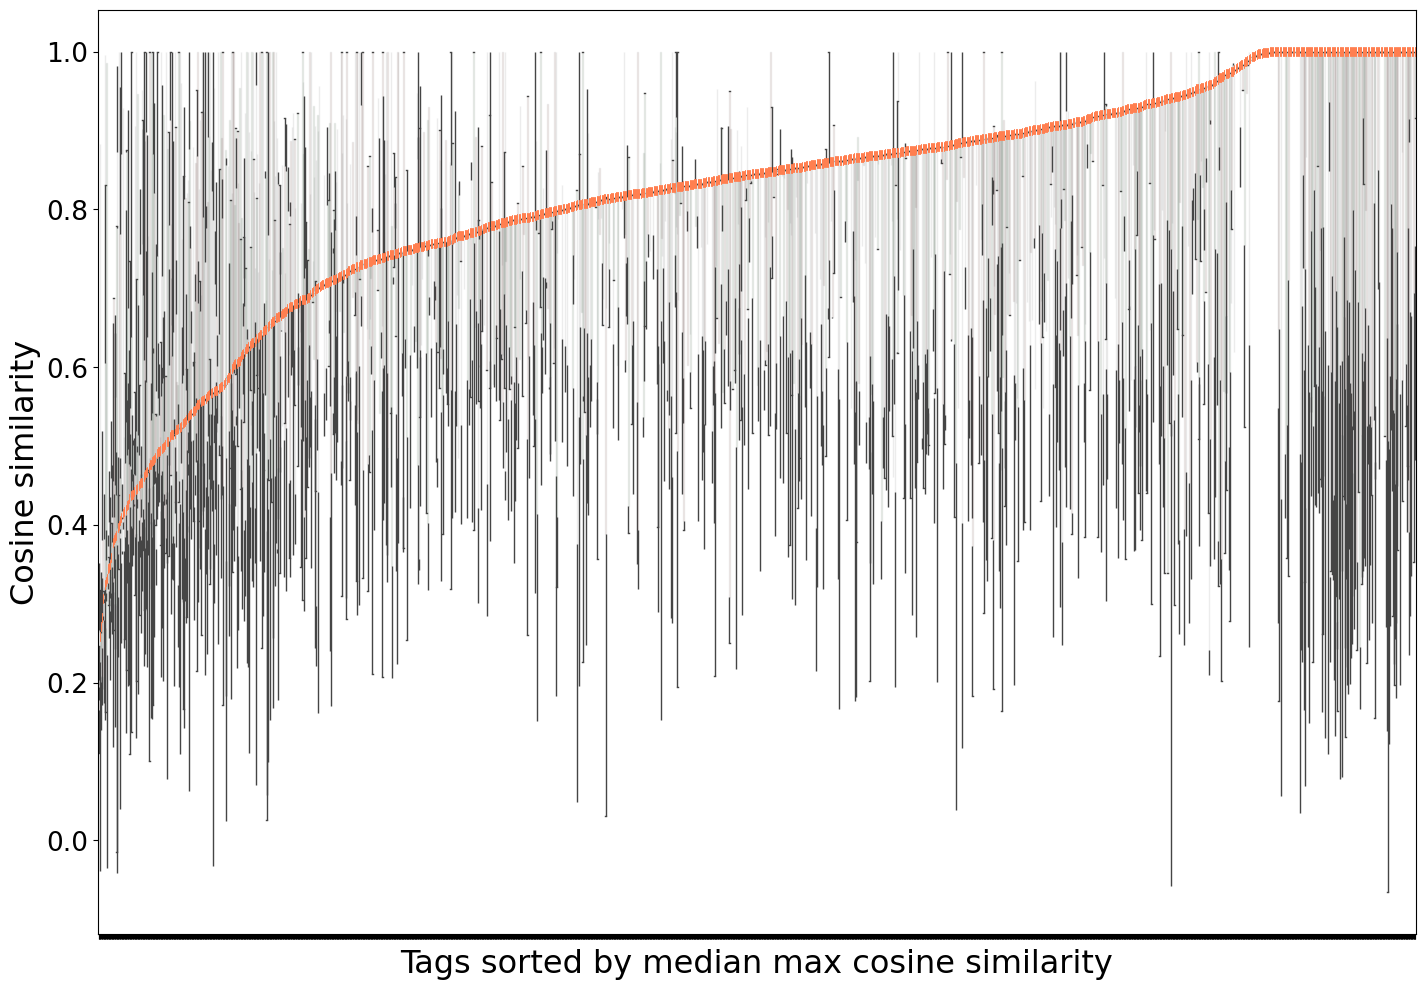

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns


meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
plt.figure(figsize=(17,12))
bplot = sns.boxplot(
    data=[x for x in to_plot2],
    palette=[sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"]],
    showfliers=False,
    showmeans=False,
    #saturation = 0.5,
    medianprops={"color": "coral", 'linewidth': 7},
    boxprops=dict(alpha=.1)
)

# Adjust the transparency of the boxes and lines
"""for patch in plt.gca().artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.2))  # Set box transparency to 0.5"""

bplot.set_xlabel("Tags sorted by median max cosine similarity", fontsize=23)
bplot.set_ylabel("Cosine similarity", fontsize=23)

# set the labels
bplot.set_xticklabels([])
yarray = bplot.get_yticks()

for i, y in enumerate(yarray):
  yarray[i] = round(y, 1)

bplot.set_yticklabels(yarray, size = 19)

#plt.set_title('Title', fontsize=20)
#plt.set_xlabel('Time', fontsize=16)
#plt.set_ylabel('Intensity', fontsize=16)
#plt.show()

plt.savefig("/content/mmc-bnw.pdf", format="pdf", dpi=300)

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
plt.figure(figsize=(17,12))
bplot = sns.boxplot(
    data=[x for x in to_plot2],
    palette=[sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"]],
    showfliers=False,
    showmeans=False,
    saturation = 0.5,
    medianprops={"color": "coral"}
)
bplot.set_xlabel("Tags sorted by median max cosine similarity", fontsize=30)
bplot.set_ylabel("Cosine similarity", fontsize=30)

# set the labels
bplot.set_xticklabels([])
yarray = bplot.get_yticks()

for i, y in enumerate(yarray):
  yarray[i] = round(y, 1)

bplot.set_yticklabels(yarray, size = 28)

#plt.set_title('Title', fontsize=20)
#plt.set_xlabel('Time', fontsize=16)
#plt.set_ylabel('Intensity', fontsize=16)
#plt.show()

plt.savefig("/content/mmc-bnw.pdf", format="pdf", dpi=300)

In [ ]:
to_plot2[5]

In [ ]:
sns.boxplot(data=to_plot2[5])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
# Set a wider figure size
plt.figure(figsize=(6.5, 7.5))

# Create a boxplot with blue color for the box and orange for the median
plt.boxplot(to_plot2[185], patch_artist=True, medianprops={'color': 'orange'}, widths=0.3)

# Customize the box color
"""colors = ['blue']
for patch, color in zip(plt['boxes'], colors):
    patch.set_facecolor(color)"""

plt.title("Tag: Angiogram - Boxplot", size=19.5)
plt.ylabel("Maximum cosine similarity", size=19.5)
# Remove x-axis label
plt.xticks([])
# Increase the size of y-axis ticks
plt.yticks(fontsize=18.5)
#plt.subplots_adjust(right=0.15)

#plt.show()

plt.savefig('/content/angiogram.pdf')

In [ ]:
bplot = sns.boxplot(
    data=to_plot2[185],
    #palette=[sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"]],
    showfliers=True,
    showmeans=True,
    #saturation = 0.5,
    medianprops={"color": "coral"}
)

In [ ]:
def avg(l):
  res = sum(l) / len(l)
  return res


In [ ]:
tags_dict_backup = tags_dict

In [ ]:
import statistics
tags_dict_3 = dict()
for k in sorted_dict2.keys():
  counter = 0
  if len(tags_dict[k]) > 0:
    tags_dict_3[k] = [np.min(tags_dict[k]), np.quantile(tags_dict[k], 0.25), avg(tags_dict[k]), statistics.median(tags_dict[k]), np.quantile(tags_dict[k], 0.75), np.max(tags_dict[k])]
  else:
    counter += 1



print('Finished loop!', counter, 'lists with zero-size.')

In [ ]:
tags_dict_3

In [ ]:
df_plot = pd.DataFrame.from_dict(tags_dict_3, orient='index', columns=['min', 'q25', 'avg', 'median', 'q75', 'max'])

In [ ]:
df_plot

In [ ]:
# plot lines
plt.figure(figsize=(16,10))
plt.plot(df_plot['min'], label = "min")
plt.plot(df_plot['q25'], label = "quantile 25")
#plt.plot(df_plot['avg'], label = "avg")
plt.plot(df_plot['median'], label = "median")
plt.plot(df_plot['q75'], label = "quantile 75")
plt.plot(df_plot['max'], label = "max")
plt.legend()
plt.show()

In [ ]:
to_remove = []
for k in tags_dict.keys():
  if len(tags_dict[k]) != 4:
    to_remove.append(k)

for r in to_remove:
  tags_dict.pop(r)

In [ ]:
df = pd.DataFrame.from_dict(tags_dict, orient='index')

In [ ]:
#df.to_csv('/content/gdrive/MyDrive/ImageCLEF2023/median-max-cos-sim.csv')

In [ ]:
! git clone https://github.com/ipavlopoulos/lm.git
! pip install nltk

In [ ]:
df_train=pd.read_csv('/content/gdrive/MyDrive/imageclef23/imageclef2023_captions_train_mysplit.csv', sep=',', encoding='latin')

In [ ]:
df_train.head()

In [ ]:
!pip install transformers

In [ ]:
from lm.neural.models import RNN, load_model
import pickle
import transformers

rnn = RNN()
model_path = '/content/gdrive/MyDrive/imageclef23/rnn_fast_model'
rnn.model = load_model(model_path+".h5")
rnn.tokenizer = pickle.load(open(model_path+".tkn", "rb"))
rnn.set_up_indices()

In [ ]:
cherry_picked_caption = ''

In [ ]:
# I need the max cosine similarity between the caption embeddings and the concept embeddings.

In [ ]:
def dmm_loss(caption_embeds, concept_embeds, concept):
  # dmm loss = (maxcos(caption) - medianmax(tag))^2

  # dmm loss = (maxcos(caption) - tags_dict2[tag])^2
  cos_t = compute_sims(concept_embeds, caption_embeds)
  cos_t[0] = [x for x in cos_t[0] if str(x) != 'nan']
  print(cos_t[0])
  max_cos_t = np.max(cos_t[0])
  print('max cos t:', max_cos_t)

  max_cos_c = sorted_dict2[concept][0]
  print('max cos c:', max_cos_c)

  dmm = (max_cos_t - max_cos_c) ** 2
  return dmm

In [ ]:
dmm_loss(my_caption_0_embeddings, my_concept_0_embeddings, my_concept_0[0])

In [ ]:
typical_bs_loss = rnn.cross_entropy('Head CT')

In [ ]:
typical_bs_loss

In [ ]:
a = 0.5
histogram_conf = 0.5
dmm_loss = (a * histogram_conf * dmm_loss(my_caption_0_embeddings, my_concept_0_embeddings, my_concept_0[0])) + ((1-a*histogram_conf) * typical_loss)